# Part IV: Eigenfaces

In [195]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import os

### Helper Functions

In [196]:
def show(image, title ="", size = 15):
    width, height = image.shape[0], image.shape[1]
    aspect_ratio = width/height
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

In [197]:
def load_faces():
    '''
    Load the images from the att_faces dataset
    Returns:
    faces: A list of images
    labels: A list of labels corresponding to the images
    '''
    faces = []
    labels = []
    for i in range(1,41):
        images = os.listdir('./att_faces/s'+str(i))
        for image in images:
            img = cv.imread('./att_faces/s'+str(i)+"/"+image,0)
            faces.append(img)
            labels.append(i)
    return faces, labels


In [198]:
def preprocessing(img):
    '''
    Preprocess the image by converting it to grayscale and resizing it to 92x92
    img: image to be preprocessed
    return: preprocessed image
    '''
    if len(img.shape) > 2:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, (92,92))
    return img

 ### 1 - Preprocess the images in the chosen dataset by resizing them to a uniform dimension (e.g., 100×100 pixels) and converting them to grayscale. 

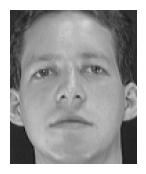

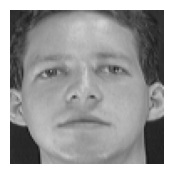

In [199]:
faces, labels = load_faces()
show(faces[0], size=2)

assert len(faces) > 0 , "No faces loaded"
faces = list(map(preprocessing, faces))

show(faces[0], size=2)

 #### Then, flatten each image into a 1D vector.

In [200]:
faces_data = np.array([f.flatten() for f in faces])
labels = np.array(labels)

### 2 -	Implement the PCA (Principal Component Analysis) algorithm to compute the eigenvalues and eigenvectors. 

#### Finding mean and center

In [201]:
mean = np.mean(faces_data, axis=0)
print(mean.shape)

center = faces_data - mean
print(center.shape)

(8464,)
(400, 8464)


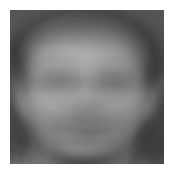

In [202]:
# doing nothing .. just curious
image = mean.reshape((92, 92))
image_uint8 = image.astype(np.uint8)
show(image_uint8, size=2)

#### Finding covariance matrix

In [203]:
cov_matrix = np.cov(center, rowvar=False)
print(cov_matrix.shape)

(8464, 8464)


#### Finding eigenvalues and eigenvectors

In [204]:
eigenvalues, eigenvectors = LA.eigh(cov_matrix)

In [205]:
print(eigenvalues.shape)
print(eigenvectors.shape)

(8464,)
(8464, 8464)


### 3 -	Extract the top K principal components (eigenfaces), which capture the most variance in the dataset. Then visualize the top 10 and top 25 eigenfaces. To better visualize eigenfaces, apply a color map: [OpenCV: ColorMaps in OpenCV](https://docs.opencv.org/4.10.0/d3/d50/group__imgproc__colormap.html). 

In [206]:
# Sort the eigenvectors and eigenvalues in decreasing order 
sorted_indices = np.argsort(eigenvalues)[::-1] 
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

print(sorted_eigenvalues[0])
print(sorted_eigenvectors[0])

2317869.6918085874
[-2.30637970e-03  1.62077736e-02 -2.20302531e-02 ... -9.34214752e-19
  0.00000000e+00  0.00000000e+00]


In [207]:
def show_top_k_eigenfaces(k, sorted_eigenvectors, colorMapType=cv.COLORMAP_JET):
    top_eigenvectors = sorted_eigenvectors[:, :k]
    _, axes = plt.subplots(k//5, 5, figsize=(15, k//5*3))
    for i in range(k):
        eigenface = top_eigenvectors[:, i].reshape((92, 92))
        # Normalize the eigenface for visualization and convert to uint8
        eigenface_normalized = cv.normalize(eigenface, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
        eigenface_colormap = cv.applyColorMap(eigenface_normalized, colorMapType)
        eigenface_colormap = cv.cvtColor(eigenface_colormap, cv.COLOR_BGR2RGB)
        ax = axes[i // 5, i % 5]
        ax.imshow(eigenface_colormap)
        ax.axis('off')
        ax.set_title(f'Eigenface {i+1}')
    plt.suptitle(f'Top {k} Eigenfaces', fontsize=16)
    plt.tight_layout()
    plt.show()


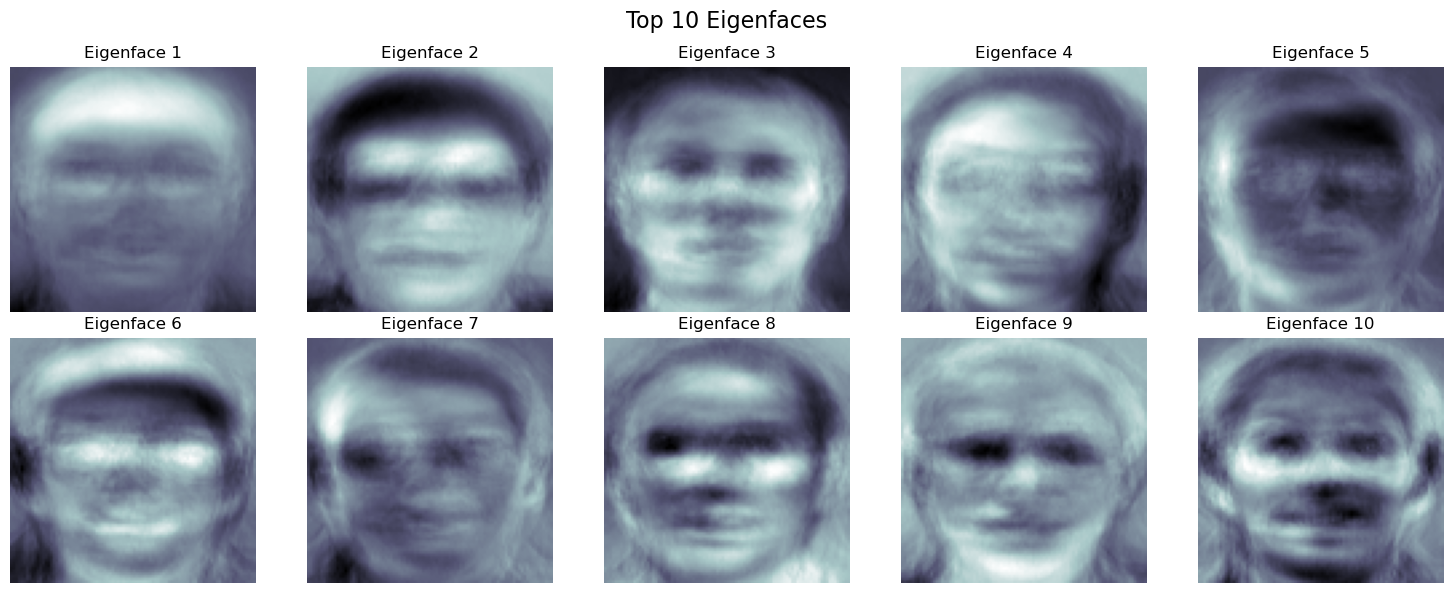

In [208]:
# show_top_k_eigenfaces(10, sorted_eigenvectors)
show_top_k_eigenfaces(10, sorted_eigenvectors, cv.COLORMAP_BONE)

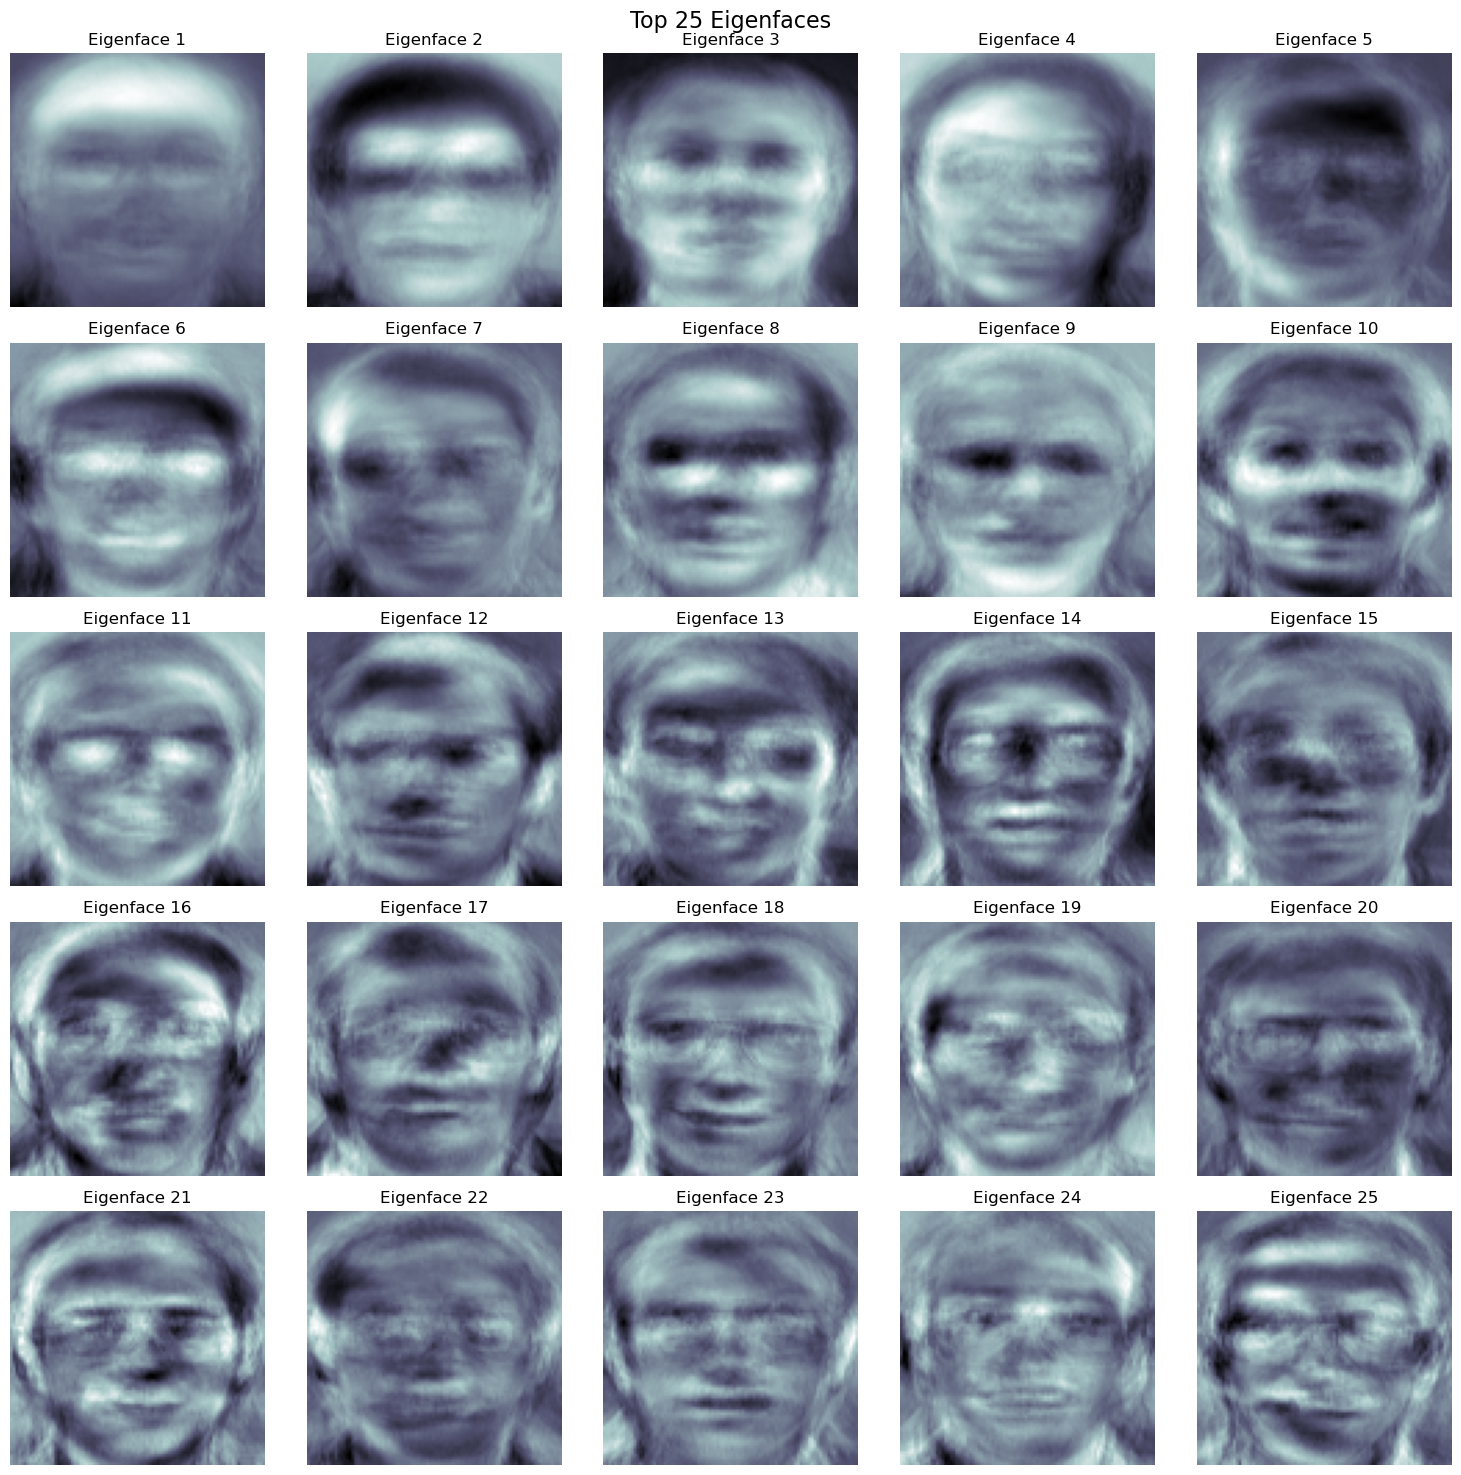

In [209]:
# show_top_k_eigenfaces(25, sorted_eigenvectors)
show_top_k_eigenfaces(25, sorted_eigenvectors, cv.COLORMAP_BONE)

### 4-	Reconstruct an example face image using different values of K (the number of eigenfaces). Use numpy.arange(25, 300, 25, dtype=int) for the number of eigenfaces. Display the original image alongside the reconstructed images for comparison. Paste the results here. 

In [215]:
k_values = np.arange(25, 300, 25, dtype=int)

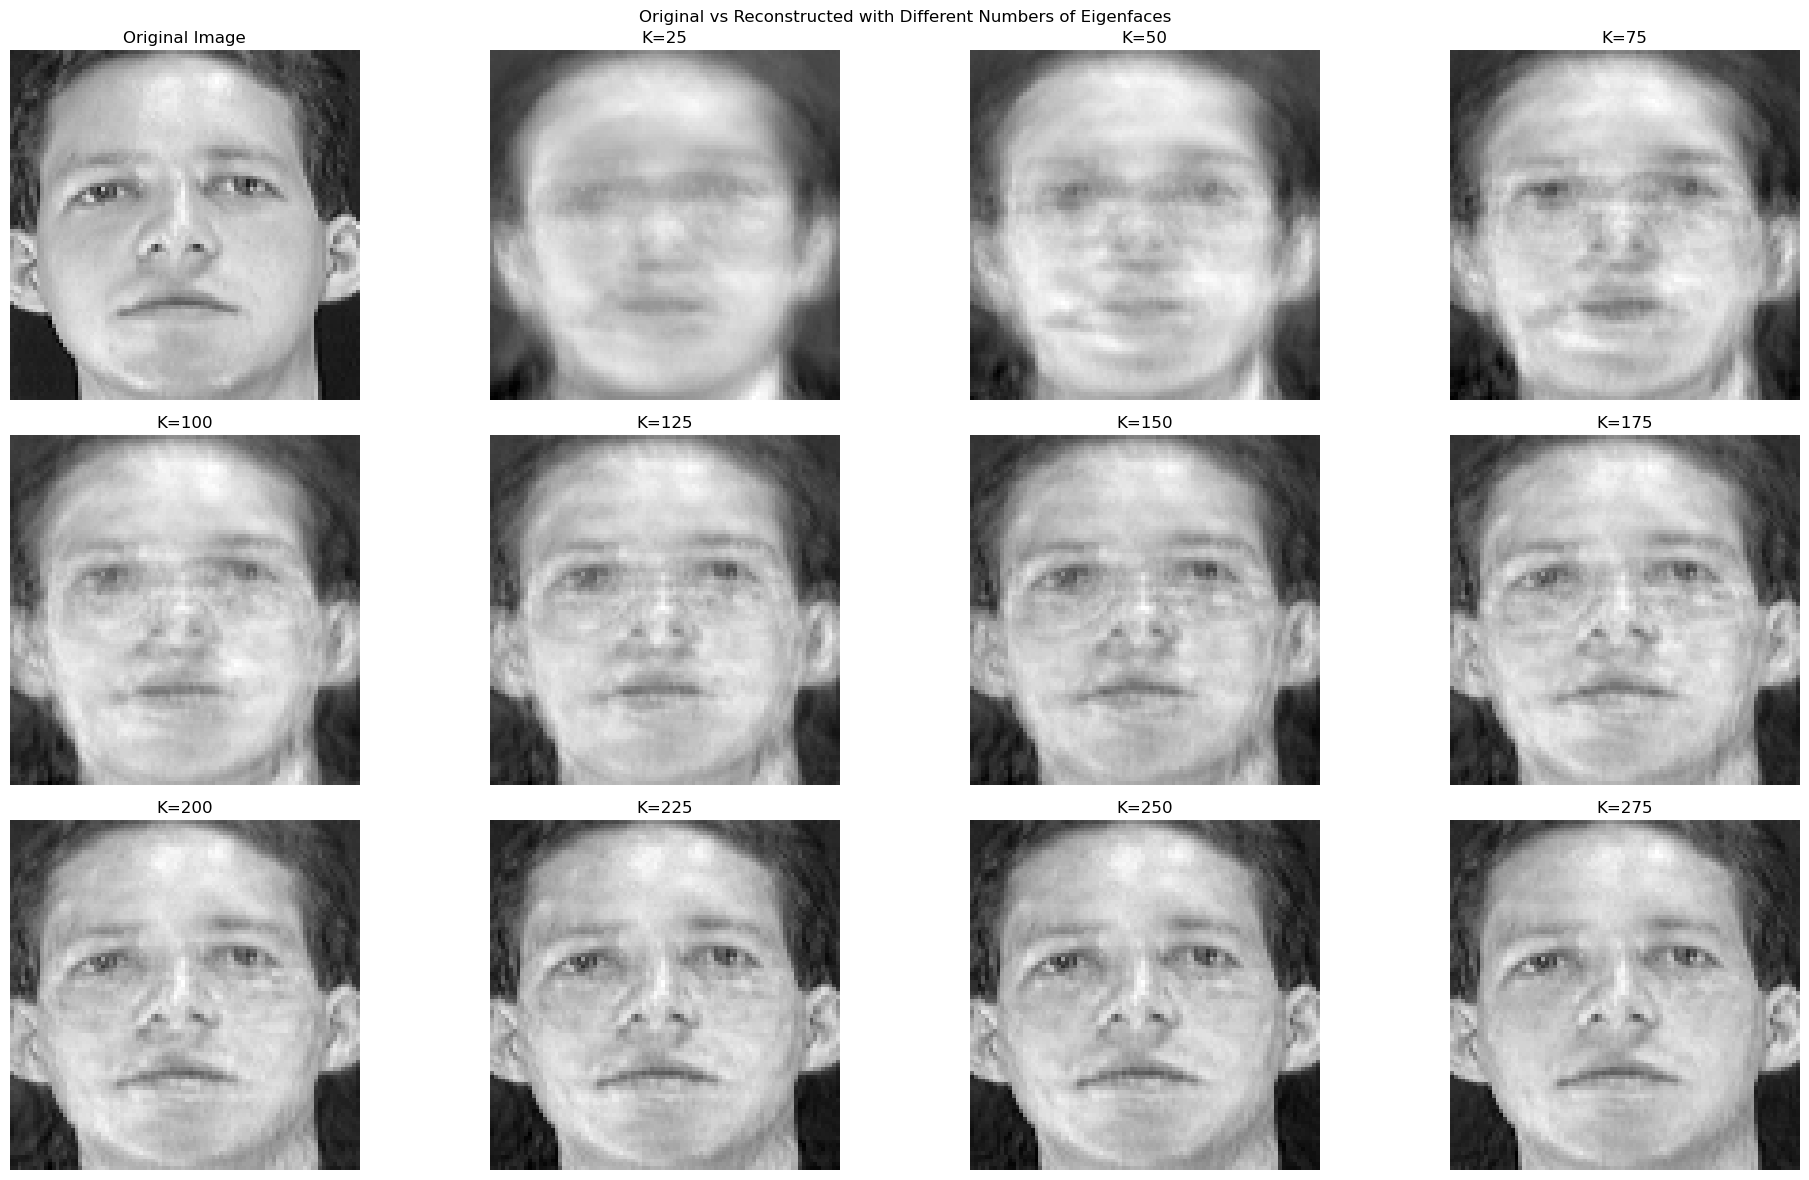

In [221]:
reconstructed_faces = []
idx = 0
example_face = faces[idx]
example_center = center[idx]

for k in k_values:
    top_k_eigenvectors = sorted_eigenvectors[:, :k]
    # Project the centered image onto the top K eigenvectors
    projection = np.dot(example_center, top_k_eigenvectors)
    # Reconstruct the image from the projection
    reconstruction = mean + np.dot(projection, top_k_eigenvectors.T)
    # Append the reconstructed image to the list
    reconstructed_faces.append(reconstruction)


num_reconstructions = len(k_values)
fig, axes = plt.subplots(3 , (num_reconstructions + 1) // 3, figsize=(20, 12))
axes = axes.flatten()

# Display the original image
original_image = faces_data[0].reshape((92, 92))
axes[0].imshow(original_image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')

# Display reconstructed images
for i, reconstruction in enumerate(reconstructed_faces):
    reconstructed_image = reconstruction.reshape([92, 92])
    reconstructed_image_normalized = cv.normalize(reconstructed_image, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

    axes[i + 1].imshow(reconstructed_image_normalized, cmap='gray')
    axes[i + 1].axis('off')
    axes[i + 1].set_title(f'K={k_values[i]}')

plt.suptitle('Original vs Reconstructed with Different Numbers of Eigenfaces')
plt.tight_layout()
plt.show()

### 5 -	What is being done in Part IV-3 and Part IV-4? Explain.